**The feedback-control upsampling consists of three steps: deconvolution, re-convolution, and pixel substitution.**

<img src="images/process.png" width=1100 height=400 />

#### Image degradation process from H (high resolution) to L (low resolution)
$$ L = (f \otimes H) \downarrow^{d} \ \ \ \ \ (1)$$

where $\downarrow^{d}$ is a decimating (subsampling) operator with factor d. This equation can be split into two steps, describing a convolution followed by a decimation process:
$$ \tilde{H} = f \otimes H, \ L = \tilde{H} \downarrow^{d} \ \ \ \ \ (2)$$

where $\tilde{H}$ is the linearly filtered high-resolution image. If these two steps can be approximately inverted, that is, by first upsampling the image and then deconvolving it using the linear filter, a reliable upsampling process can be yielded.

However, minimizing
$$ \parallel f \otimes H - \tilde{H} \parallel_2^{2} \ \ \ \ \ (3)$$
by solving $ WH = L$ where $W$ represent the convolution matrix is not a well-posed problem because $W$ does not always have an exact inverse and is easily
influenced by noise.

This paper adpots a **non-blind deconvolution** method. The process is explained below.

### The Deconvolution Process

#### Regularization term in the deconvolution process:
Recent research has shown that natural image gradients generally follow a heavytailed distribution, indicating that most pixels have small gradient magnitudes whereas salient structures are present. Adding a prior term to equation (3)  makes the deconvolution well-posed and helps find a unique solution.
<center><img src="images/phi.png" width=500 height=500 /></center>
$$
\Phi(x) = \left\{
    \begin{array}\\
        -k|x| & \mbox{if } \ x \le l_t \\
        -(ax^{2}+b) & \mbox{if } \ x \gt l_t \\
    \end{array}
\right.
\ \ \ \ \ \ \ \ \ \ (4)
$$

Above is a piece-wise convex function where x denotes the image gradient level and $ l_t $ indexes the position where the two functions are concatenated.
In Figure 1, $−k|x|$, shown in green, represents the sharp peak in the distribution at the center, while $ −(ax^{2}+b) $ models the heavy tails of the distribution. $\Phi(x)$ is central-symmetric, and k, a, and b are the curve fitting parameters computed by minimizing the least square fitting error. By incorporating such prior into the regularization term for the deconvolution process, we are subject to minimize the following energy function:

$$ E(H) \propto \ \parallel f \otimes H - \tilde{H} \parallel_2^{2} + \ \lambda_1(\parallel \Phi(\partial_x H) \parallel_1 + \parallel \Phi(\partial_y H) \parallel_1) \ \ \ \ \ \ \ \ \ \ (5)$$

where $\partial_x H$ and $\partial_y H$ respectively denote the values of the x- and y-direction gradient, and $\lambda_1$ is a weight.

#### Variable substitution:
To make the optimization efficient and robust, this paper uses the variables substitution scheme. By using $\mu = (\mu_x, \mu_y)$ to substitute $\partial H = (\partial_x H, \partial_y H)$, and add an additional term to measure the difference between $\partial H$ and $\mu$:
$$ E(H, \mu) = \ \parallel f \otimes H - \tilde{H} \parallel_2^{2} + \ \lambda_1(\parallel \Phi(\mu_x) \parallel_1 + \parallel \Phi(\mu_y) \parallel_1) + \ \lambda_2(\parallel \mu_x - \partial_x H \parallel_2^{2} + \parallel \mu_y - \partial_y H \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (6)$$

where $\lambda_2$ is a weight to control the relative importance that $\mu$ and $\partial H$ have similar values.

The purpose of using this variable substitution scheme is to separate $\Phi(\partial H)$ from $ \parallel f \otimes H - \tilde{H} \parallel_2^{2}$ in optimization, thus making it possible to use FFT to accelerate the convolution process.

The values of $\mu$ and $\partial H$ will eventually be quite similar, since the weight $\lambda_2$ will be progressively increased in iterations.

#### Two step optimization:
- $\mu$ Step: fix$H$to optimize $\mu$
    $$ E(\mu) = \lambda_1(\parallel \Phi(\mu_x) \parallel_1 + \parallel \Phi(\mu_y) \parallel_1) + \ \lambda_2(\parallel \mu_x - \partial_x H \parallel_2^{2} + \parallel \mu_y - \partial_y H \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (7)$$
  Or,
  $$ E(\mu) = \Sigma_{x,y} (E(\mu_x (x,y)) + E(\mu_y (x,y))) \ \ \ \ \ \ \ \ \ \ (8)$$
Since each $E(\mu(x, y))$ is not related to other energy elements, and it only contains one variable $\mu(x, y)$, we decompose the multi-variable optimization
problem into a set of single-variable minimization problems. $E(\mu(x, y))$ consists of convex, differentiable pieces, eachof which is minimized separately and the minimum among them is chosen. This optimization step can be completed quickly, resulting in a global minimum for $E(\mu(x, y))$.
- $H$ Step: fix$\mu$ to minimize$H$
$$ E(H) = \ \parallel f \otimes H - \tilde{H} \parallel_2^{2} + \ \lambda_2(\parallel \mu_x - \partial_x H \parallel_2^{2} + \parallel \mu_y - \partial_y H \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (9)$$
Using Plancherel’s theorem:
$$ E(H) = \ \parallel \mathcal{F}(f) \circ \mathcal{F}(H) - \mathcal{F}(\tilde{H}) \parallel_2^{2} + \ \lambda_2(\parallel \mathcal{F}(\mu_x) - \mathcal{F}(\partial_x) \circ \mathcal{F}(H) \parallel_2^{2} + \parallel \mathcal{F}(\mu_y) - \mathcal{F}(\partial_y) \circ \mathcal{F}(H) \parallel_2^{2}) \ \ \ \ \ \ \ \ \ \ (10)$$

By setting $\partial E(H)/ \partial F(H) = 0$, we obtain an optimal $\mathcal{F}^{*}(H)$ that minimize $E(H)$:

$$
\mathcal{F}^{*}(H) = \frac
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(\tilde{H}) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\mu_x) + \lambda_2 \overline{\mathcal{F}(\lambda_y)} \circ \mathcal{F}(\mu_y)}
{\overline{\mathcal{F}(f)} \circ \mathcal{F}(f) + \lambda_2 \overline{\mathcal{F}(\partial_x)} \circ \mathcal{F}(\partial_x) + \lambda_2 \overline{\mathcal{F}(\partial_y)} \circ \mathcal{F}(\partial_y)}
$$

where $\overline{(.)}$ is the conjucate operator and $\mathcal{F}$ is FFT operation.

Finally, $ H^{*} = \mathcal{F}^{-1}(\mathcal{F}^{*}(H)) $

The above two steps iterate until convergence. We set $\lambda_2$ = 20 initially. Then, we triple its value in each iteration to make $\mu$ and $\partial H$ similar at convergence. $\lambda_1$ is adjustable in range [0.01 − 0.3] in this experiments.

In [291]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.ndimage as nd
import seaborn as sns
import pandas as pd
import scipy.sparse.linalg
from scipy import optimize
import pwlf

In [10]:
COLOR = "black"
FONT = 20
def show_two_rgb(im1, title1, im2, title2, figsize=(16, 12)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(im1)
    axes[0].set_title(title1, color=COLOR, fontsize=FONT)
    axes[0].tick_params(colors=COLOR, which='both')
    axes[1].imshow(im2)
    axes[1].set_title(title2, color=COLOR, fontsize=FONT)
    axes[1].tick_params(colors=COLOR, which='both')

In [ ]:
def upsample_bicubic_by_two(low_res):
    return cv2.resize(low_res, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

In [ ]:
def deconvolve(upsampled_img, f):
    '''

    :param upsampled_img: this is ˜H
    :param f: this is the kernel that H is convolved with
    :return : returns H
    '''



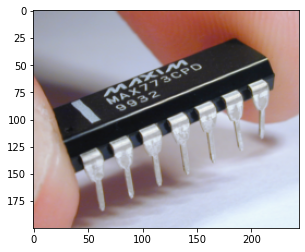

(200, 244, 3)


In [45]:
img = cv2.cvtColor(cv2.imread('images/chip_input.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.imshow(img)
plt.show()
print(img.shape)

In [46]:
def gradient(img, x = True, y = True):

    f1 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    f2 = np.array([[-1,-2,-1], [0,0,0], [1,2,1]]).T

    vert_gradient =nd.correlate(img, f1)
    horz_gradient =nd.correlate(img, f2)

    if x:
        return(horz_gradient)
    else:
        return (vert_gradient)

In [47]:
Rx = gradient(img[:,:,0], y = False)
Ry = gradient(img[:,:,0], x = False)
Gx = gradient(img[:,:,1], y = False)
Gy = gradient(img[:,:,1], x = False)
Bx = gradient(img[:,:,2], y = False)
By = gradient(img[:,:,2], x = False)

In [160]:
gradR = np.sqrt(np.square(Rx) + np.square(Ry))
gradG = np.sqrt(np.square(Gx) + np.square(Gy))
gradB = np.sqrt(np.square(Bx) + np.square(By))

In [161]:
grad = np.dstack((gradR,gradG,gradB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


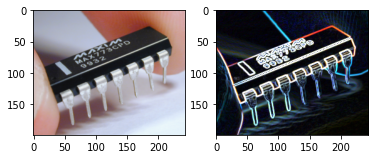

In [162]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(grad)
plt.show()

In [241]:
gradR_norm = cv2.normalize(gradR, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
gradR_norm = gradR_norm.astype(np.uint8)

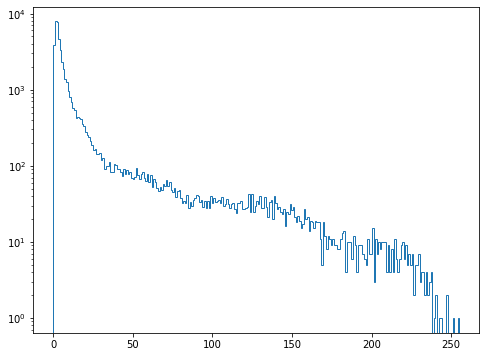

In [244]:
# mirror = gradR_norm[:, ::-1] * -1
# gradR_mirrored = np.concatenate((mirror ,gradR_norm),axis=1)
# r = gradR_mirrored.flatten()
r = gradR_norm.flatten()
plt.figure(figsize=(8, 6))
# counts, bins, bars = plt.hist(r, log=True, bins=511,range=(-255,255),facecolor="r", histtype = 'step')
counts, bins, bars = plt.hist(r, log=True, bins=256,range=(0,255),facecolor="r", histtype = 'step')
plt.show()

In [245]:
df = pd.Series(r).value_counts().reset_index()
df.columns = ['val', 'count']

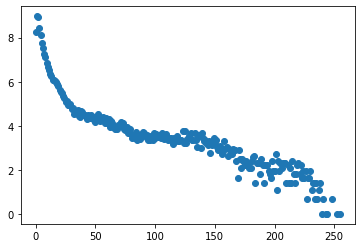

In [247]:
plt.scatter(df['val'], np.log(df['count']))
# plt.scatter(df['val'], df['count'])
plt.show()

In [217]:
# r_df = pd.Series(r)
# r_df.plot.density(color='green', logx=True)
# # r_df.plot.kde(color='green')
# plt.title('Density Plot for gradient')
# plt.show()

In [250]:
print("counts, bins: ", len(counts), len(bins), len(df['count']))

counts, bins:  256 257 246


In [257]:
# input = np.linspace(0, 255, len(df['count']))
input = np.array(df['val'])

In [293]:
my_pwlf = pwlf.PiecewiseLinFit(input, np.log(df['count']))
breaks = my_pwlf.fit(2)
print(breaks)
l_t = breaks[1]

[  0.          24.50683926 255.        ]


In [294]:
print(l_t)

24.506839263159126


In [295]:
def piecewise(x, k, f, a, b):
    return np.piecewise(x, [x <= l_t, x > l_t], [lambda x: -k*abs(x) + f, lambda x: -1 * (a * (x ** 2) + b)])


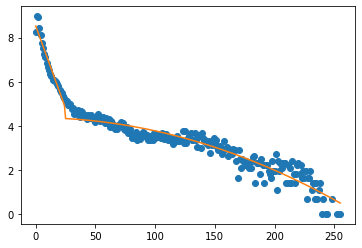

In [296]:
p , e = optimize.curve_fit(piecewise, input,  np.log(df['count']))
xd = np.linspace(0, 255, len(df['count']))
plt.plot(input,  np.log(df['count']), "o")
plt.plot(xd, piecewise(xd, *p))
plt.show()

In [309]:
k, f, a, b = p[0], p[1], p[2], p[3]
print("k={:.10f}, f={:.10f}, a={:.10f}, b={:.10f}: ".format(k, f, a, b))


k=0.1498408842, f=8.5234181291, a=0.0000594768, b=-4.3641614764: 


In [299]:
print(p)

[ 1.49840884e-01  8.52341813e+00  5.94768410e-05 -4.36416148e+00]


In [219]:
print(len(df['count']))

491
